In [1]:
import tensorflow as tf

In [2]:
from tensorflow import keras

In [3]:
import keras_tuner as kt

In [198]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [200]:
df = pd.read_csv('airfoil_self_noise.dat',delimiter='\t',names=['Freq','alpha','C','Uinf','del','Noise'],index_col=None)

In [201]:
df.head()

,Freq,alpha,C,Uinf,del,Noise
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


In [203]:
df['Rey'] = df['Uinf']*df['C']/1.48E-5

In [206]:
df = df[['Freq','alpha','C','Uinf','del','Rey','Noise']]
df.head()

,Freq,alpha,C,Uinf,del,Rey,Noise
0,800,0.0,0.3048,71.3,0.002663,1.468395e+06,126.201
1,1000,0.0,0.3048,71.3,0.002663,1.468395e+06,125.201
2,1250,0.0,0.3048,71.3,0.002663,1.468395e+06,125.951
3,1600,0.0,0.3048,71.3,0.002663,1.468395e+06,127.591
4,2000,0.0,0.3048,71.3,0.002663,1.468395e+06,127.461


### This problem has the following inputs:
    1. Frequency, in Hertzs.
    2. Angle of attack, in degrees.
    3. Chord length, in meters.
    4. Free-stream velocity, in meters per second.
    5. Suction side displacement thickness, in meters.

###  The only output is:
    6. Scaled sound pressure level, in decibels.

In [7]:
df.isnull().sum()

Freq     0
alpha    0
C        0
Uinf     0
del      0
Noise    0
dtype: int64

In [238]:
df['Rey'].unique()

array([1468394.59459459, 1143000.        ,  815545.94594595,
        652848.64864865, 1101295.94594595,  857250.        ,
        611659.45945946,  489636.48648649,  734197.2972973 ,
        571500.        ,  407772.97297297,  326424.32432432,
        244732.43243243,  190500.        ,  135924.32432432,
        108808.10810811,  122366.21621622,   95250.        ,
         67962.16216216,   54404.05405405,  489464.86486486,
        381000.        ,  271848.64864865,  217616.21621622])

### exploratory data analysis


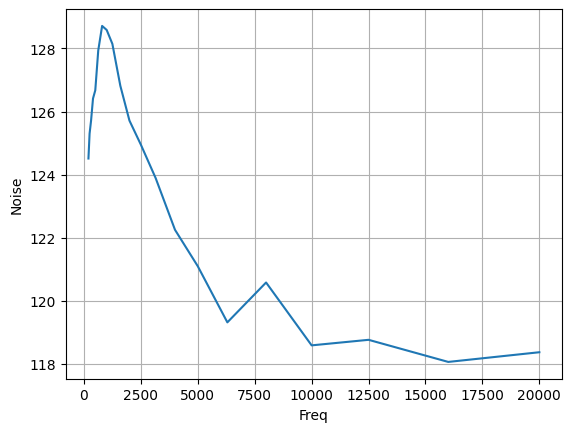

In [244]:
sns.lineplot(x='Freq',y='Noise',data=df,estimator='mean',err_style=None)
plt.grid("both")

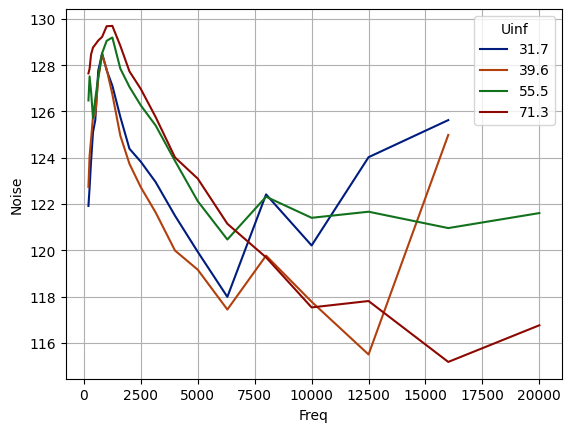

In [261]:
sns.lineplot(x='Freq',y='Noise',data=df,estimator='mean',err_style=None,hue='Uinf',palette='dark',ci=99)
plt.grid("both")

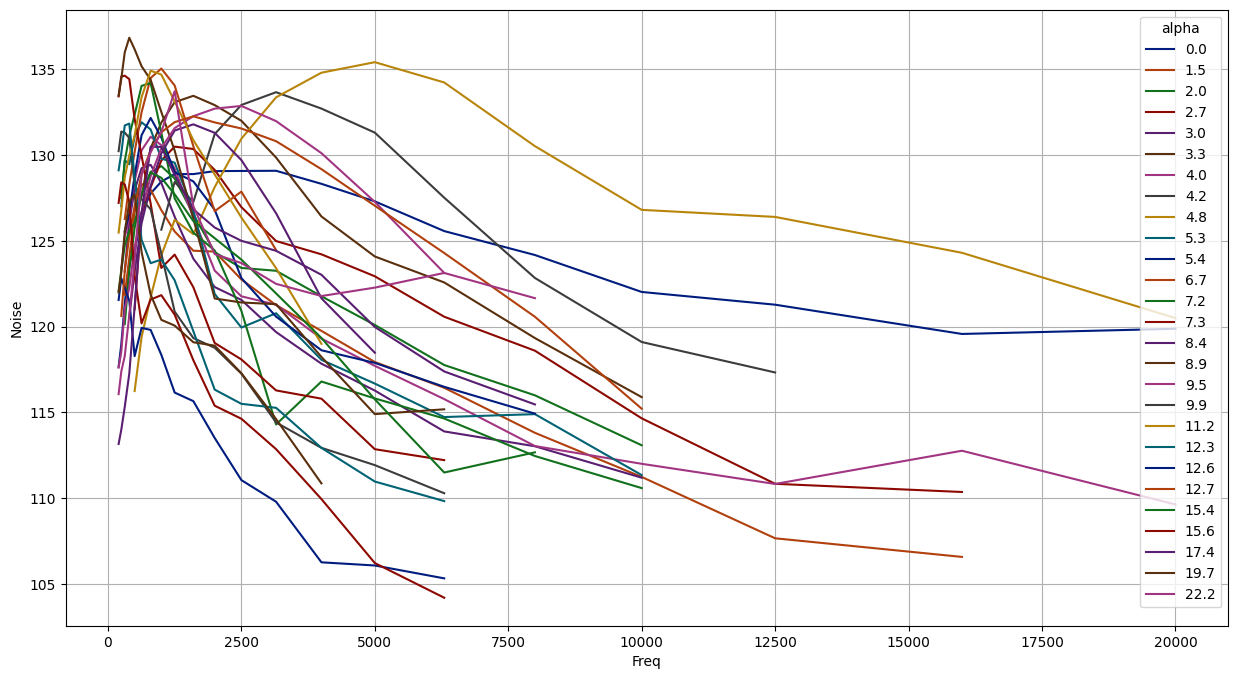

In [263]:
plt.figure(figsize=(15,8))
sns.lineplot(x='Freq',y='Noise',data=df,estimator='mean',err_style=None,hue='alpha',palette='dark',ci=99)
plt.grid("both")

In [280]:
df.sort_values(by='Rey',inplace=True)

C:\Users\nares\anaconda3\envs\ineurontf\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


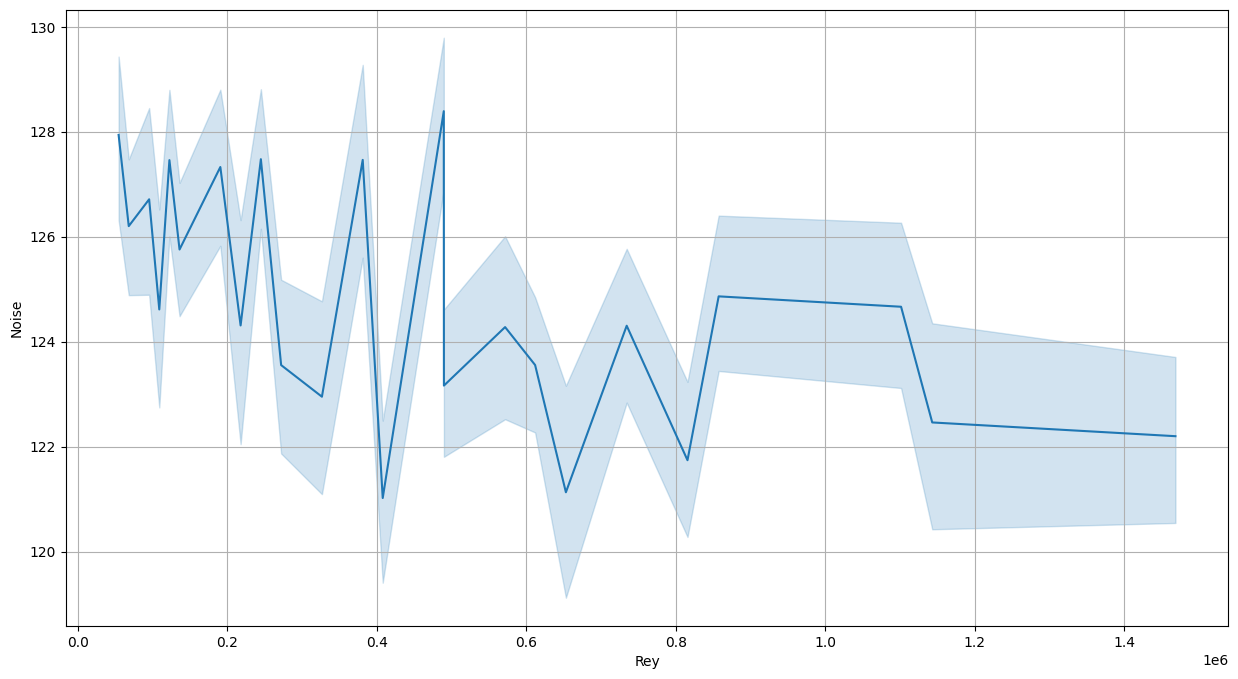

In [283]:
plt.figure(figsize=(15,8))
sns.lineplot(df['Rey'],df['Noise'],estimator='mean')
plt.grid("both")

In [284]:
df['Magnitude'] = df['Noise']/df['Freq']

C:\Users\nares\anaconda3\envs\ineurontf\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


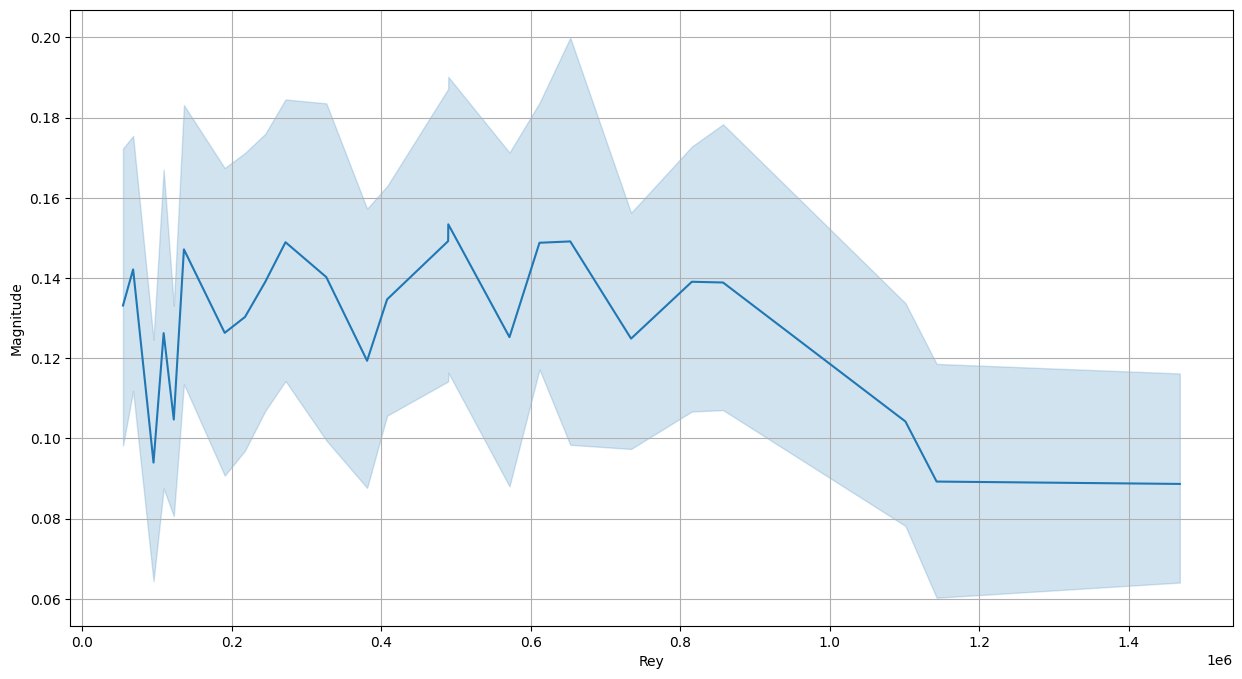

In [291]:
plt.figure(figsize=(15,8))
sns.lineplot(df['Rey'],df['Magnitude'],estimator='mean',)
plt.grid("both")

In [292]:
#the Magnitude(db/HZ) is dominant in lower freuqncies thus structures should have higher frequencies than these lower ones 
#to avoid resonance

#### Noise levels are higher at lower frequencies 
    1. Aroud 1100 hz the major tone is present 

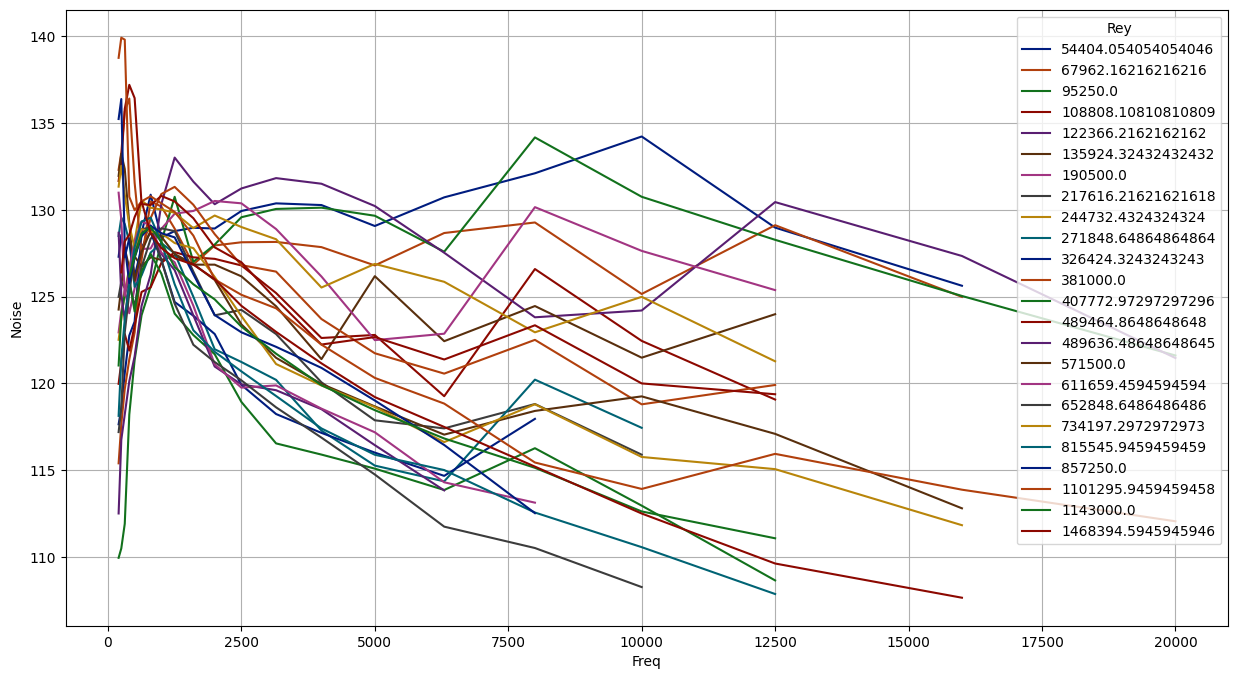

In [247]:
#Noise levels at different frequencies 
plt.figure(figsize=(15,8))
sns.lineplot(x='Freq',y='Noise',data=df,hue='Rey',estimator='mean',palette="dark",err_style=None)
plt.grid("both")

#### inferences
    1. Noise is maximum at lower frequency , as freq increases the noise decreases
    2. high reynolds number higher noise at lower frequencies while oppposite at the higher frequencies

In [293]:
df.head()

,Freq,alpha,C,Uinf,del,Rey,Noise,Magnitude
1048,1250,4.8,0.0254,31.7,0.000931,54404.054054,127.408,0.101926
1052,3150,4.8,0.0254,31.7,0.000931,54404.054054,134.268,0.042625
1051,2500,4.8,0.0254,31.7,0.000931,54404.054054,132.588,0.053035
1050,2000,4.8,0.0254,31.7,0.000931,54404.054054,130.148,0.065074
1049,1600,4.8,0.0254,31.7,0.000931,54404.054054,128.718,0.080449


In [8]:
from sklearn.preprocessing import StandardScaler

In [9]:
sc = StandardScaler()

In [10]:
from sklearn.model_selection import train_test_split

In [294]:
X = df.iloc[:,:-2]
y = df.iloc[:,-2].values.reshape(-1,1)

In [295]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [296]:
X_test.shape

(301, 6)

In [297]:
X_train_transform = sc.fit_transform(X_train)

In [298]:
layers = keras.layers.Normalization(axis=1)

In [299]:
layers.adapt(X_train)
X_train_transform = layers(X_train)


In [322]:
def model_builder(hp):
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(6,)))

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    
    hp_units = hp.Int('units_1', min_value=10, max_value=512, step=10)
    hp_units_1 = hp.Int('units_2', min_value=10, max_value=400, step=10)
    hp_activation = hp.Choice('activation',values=['relu','linear','tanh'])
    model.add(keras.layers.Dense(hp_units, activation=hp_activation))
    model.add(keras.layers.Dense(hp_units_1,activation=hp_activation))
    model.add(keras.layers.Dense(units=1))
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='huber',
                metrics=['mse'])

    return model

In [323]:
tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                            )

In [324]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [325]:
tuner.search(X_train_transform, y_train, epochs=5, validation_split=0.2, callbacks=[stop_early])

Trial 30 Complete [00h 00m 04s]
val_loss: 3.4712436199188232

Best val_loss So Far: 3.228834629058838
Total elapsed time: 00h 01m 06s
INFO:tensorflow:Oracle triggered exit


In [326]:
#Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [327]:

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is = {best_hps.get('units_1')} and in 2nd hidden layers its = {best_hps.get('units_2')} the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')} and activation as = {best_hps.get('activation')} .
#""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is = 230 and in 2nd hidden layers its = 380 the optimal learning rate for the optimizer
is 0.001 and activation as = linear .
#


In [328]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train_transform, y_train, epochs=100, validation_split=0.2,verbose=False)

In [329]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 230)               1610      
                                                                 
 dense_4 (Dense)             (None, 380)               87780     
                                                                 
 dense_5 (Dense)             (None, 1)                 381       
                                                                 
Total params: 89,771
Trainable params: 89,771
Non-trainable params: 0
_________________________________________________________________


In [330]:
val_loss_per_epoch = history.history['val_loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,),"and minimum val loss is ",min(val_loss_per_epoch))

Best epoch: 11 and minimum val loss is  3.270336151123047


In [331]:
X_test_transform = layers(X_test)

In [332]:
from sklearn.metrics import r2_score

In [333]:
y_predict = model.predict(X_test_transform)

10/10 [==============================] - 0s 2ms/step


In [334]:
import numpy as np

In [335]:
R2score =np.round(r2_score(y_test,y_predict),2)

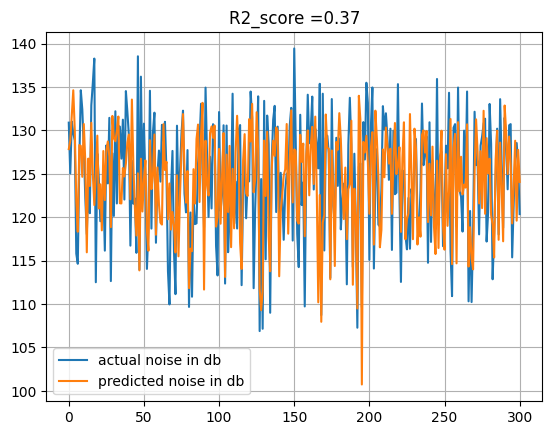

In [336]:
import matplotlib.pyplot as plt
plt.title(f"R2_score ={R2score}")
plt.plot(y_test,label='actual noise in db')
plt.plot(y_predict,label='predicted noise in db')
plt.grid("both")
plt.legend()
plt.show()

In [343]:
from sklearn.decomposition import PCA


In [374]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train)[:,0]

In [375]:
pca.explained_variance_ratio_[0]

0.9999212370435283

In [376]:
#a high variance is achieved , lets see how the regression model can be made with this 


In [377]:
def model_builder(hp):
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(1,)))

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    
    hp_units = hp.Int('units_1', min_value=10, max_value=512, step=10)
    hp_units_1 = hp.Int('units_2', min_value=10, max_value=400, step=10)
    hp_activation = hp.Choice('activation',values=['relu','linear','tanh'])
    model.add(keras.layers.Dense(hp_units, activation=hp_activation))
    model.add(keras.layers.Dense(hp_units_1,activation=hp_activation))
    model.add(keras.layers.Dense(units=1))
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='huber',
                metrics=['mse'])

    return model

In [378]:
tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                        directory='pca_ext_1',project_name='aerofoil_noise_prediction')

In [379]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [380]:
tuner.search(X_train_pca, y_train, epochs=10, validation_split=0.2, callbacks=[stop_early],batch_size=20)

Trial 30 Complete [00h 00m 07s]
val_loss: 111.14859771728516

Best val_loss So Far: 7.916088104248047
Total elapsed time: 00h 01m 19s
INFO:tensorflow:Oracle triggered exit


In [381]:
#Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [382]:
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is = {best_hps.get('units_1')} and in 2nd hidden layers its = {best_hps.get('units_2')} the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')} and activation as = {best_hps.get('activation')} .
#""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is = 80 and in 2nd hidden layers its = 310 the optimal learning rate for the optimizer
is 0.01 and activation as = tanh .
#


In [384]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train_pca, y_train, epochs=100, validation_split=0.2,verbose=False,callbacks=[stop_early])

In [387]:
X_test_pca = pca.transform(X_test)[:,0]


(301,)

In [441]:
y_predict= model.predict(X_test_pca)

10/10 [==============================] - 0s 2ms/step


In [442]:
R2score =np.round(r2_score(y_test,y_predict),2)

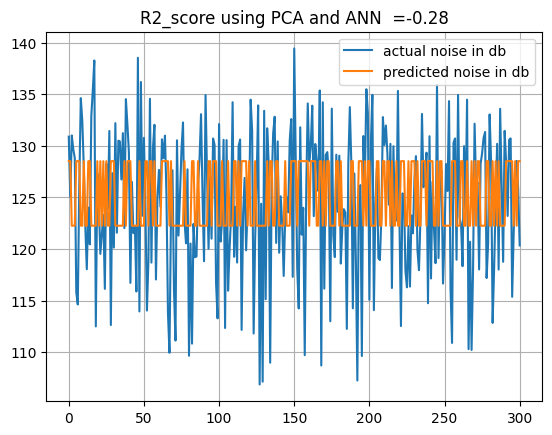

In [443]:
plt.title(f"R2_score using PCA and ANN  ={R2score}")
plt.plot(y_test,label='actual noise in db')
plt.plot(y_predict,label='predicted noise in db')
plt.grid("both")
plt.legend()
plt.show()

In [395]:
# simple regression models

In [396]:
from sklearn.linear_model import LinearRegression


In [397]:
lin_reg = LinearRegression()

In [405]:
lin_reg.fit(X_train_transform,y_train)

LinearRegression()

In [439]:

y_predict = lin_reg.predict(X_test_transform)
R2score =np.round(r2_score(y_test,y_predict),2)

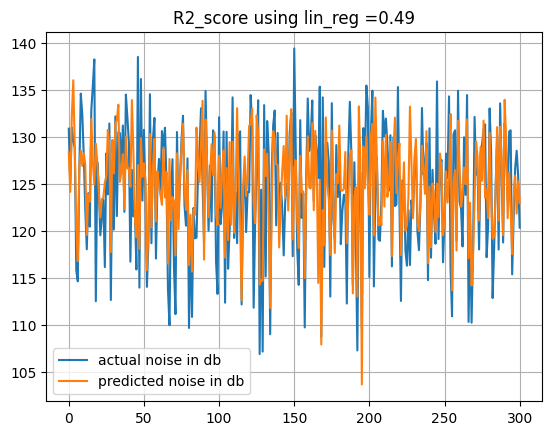

In [440]:
plt.title(f"R2_score using lin_reg ={R2score}")
plt.plot(y_test,label='actual noise in db')
plt.plot(y_predict,label='predicted noise in db')
plt.grid("both")
plt.legend()
plt.show()

In [411]:
!pip install ada-boost

In [412]:
from sklearn.ensemble import AdaBoostRegressor


In [420]:
from sklearn.model_selection import GridSearchCV


In [423]:
ada_regressor = AdaBoostRegressor()


In [427]:
params ={'n_estimators':[10,20,100,150],'learning_rate':[1,5,10,1e2,1e-2],'loss':['linear','square','exponential']}

In [428]:
grid_search_model = GridSearchCV(ada_regressor,params,cv=5)

In [434]:
import warnings
warnings.filterwarnings('ignore')

In [435]:
grid_search_model.fit(X_train,y_train)
y_predict = grid_search_model.predict(X_test)
R2score =np.round(r2_score(y_test,y_predict),2)

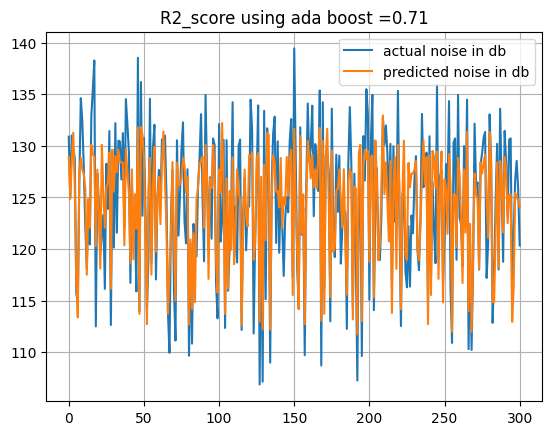

In [437]:
plt.title(f"R2_score using ada boost ={R2score}")
plt.plot(y_test,label='actual noise in db')
plt.plot(y_predict,label='predicted noise in db')
plt.grid("both")
plt.legend()
plt.show()

####  thus it is concluded that 
1. It is not necessary that Neural network will give good performance always
2. Adaboost gave the maximum r2Score of 71% 
3. PCA tranformation and ANN gave the poor r2score of -29% very very bad
